# [2주차 과제] 지도학습 모델의 회귀 및 분류 성능 비교

## 과제 목표
- 선형 모델의 한계를 확인하고, 비선형 모델(SVR, Decision Tree, Ensemble)의 성능을 비교합니다.
- 지표 해석, 규제(Regularization), Bias-Variance에 대해 학습합니다.

## 데이터셋
- 회귀: California Housing
- 분류: Wine


## 제출 지침
- 원활한 의존성 라이브러리 사용을 위해 코랩 환경에서 진행하시는 것을 권장합니다.
- 각 문항 아래 코드 셀을 실행하고, `TODO` 주석이 있는 곳을 작성하세요.
    - '___' 부분에 알맞은 코드를 작성하시면 됩니다.
- 문항별 해석(서술형) 문항은 마크다운 셀('답안'으로 명시된 부분)에 작성하세요.


In [7]:
# 공통 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report

# 스타일 및 난수 시드값 고정
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

In [8]:
# 데이터 로드

# 회귀 문제용 데이터
housing = fetch_california_housing(as_frame=True)
X_reg = housing.data.copy()
y_reg = housing.target.copy()

# 분류 문제용 데이터
wine = load_wine(as_frame=True)
X_clf = wine.data.copy()
y_clf = wine.target.copy()

print('회귀 데이터:', X_reg.shape, y_reg.shape)
print('분류 데이터:', X_clf.shape, y_clf.shape)

회귀 데이터: (20640, 8) (20640,)
분류 데이터: (178, 13) (178,)


## [Section 1] EDA & Preprocessing

### 문제 1
1. 상관관계 Heatmap을 시각화하세요.
2. 타겟과 절대 상관계수가 가장 높은 특성 2개를 확인해보세요.


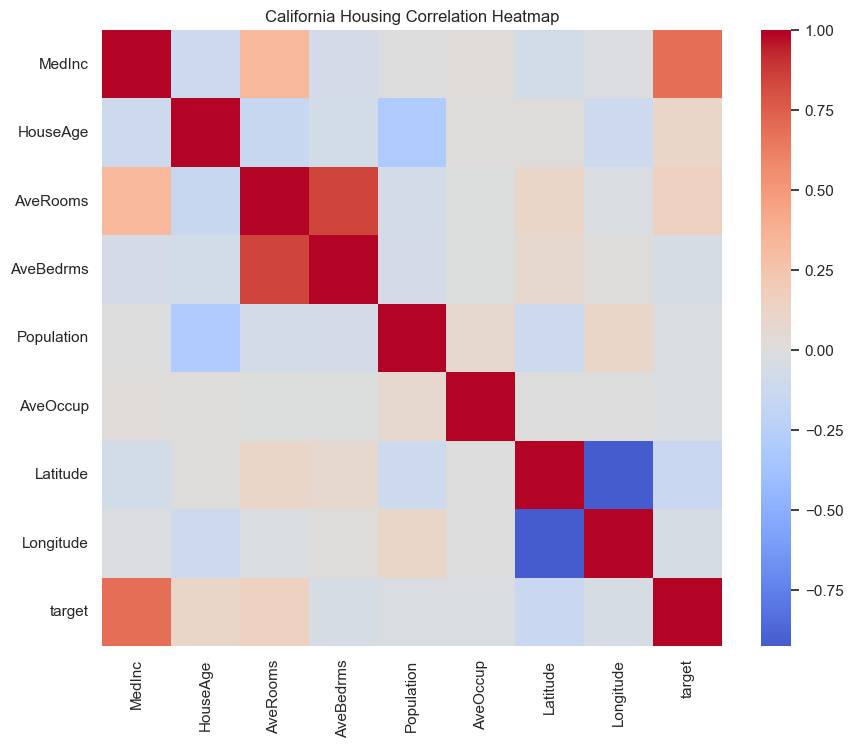

타겟과 상관계수 상위 2개 특성:
MedInc      0.688075
AveRooms    0.151948
Name: target, dtype: float64


In [9]:
# 문제 1: 회귀 데이터 상관관계 분석
reg_df = X_reg.copy()
reg_df['target'] = y_reg

# TODO 1) 상관계수 행렬 계산 메서드
corr = reg_df.corr(numeric_only=True)

# TODO 2) Heatmap 입력 데이터
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('California Housing Correlation Heatmap')
plt.show()

# TODO 3) target과 절대 상관계수 상위 2개 특성 추출
top2 = corr['target'].drop('target').abs().sort_values(ascending=False).head(2)
print('타겟과 상관계수 상위 2개 특성:')
print(top2)


### 문제 1 해석 작성
- (작성) 선택한 2개 특성이 타겟과 연관성이 높은 이유를 데이터셋을 고려하여 추론해보세요.

**답안:**
MedInc와 AveRooms가 타겟과 가장 높은 양의 상관관계를 보인 이유는 소득이 높은 지역일수록 주택 가격이 높고, 방의 개수가 많을수록 주택 규모가 커져 가격이 상승하는 경향이 있기 때문으로 해석된다.


### 문제 2
1. `StandardScaler`로 표준화를 적용하세요.
2. 선형 모델/SVM에서 표준화가 중요한 이유를 서술하세요.


In [10]:
# 문제 2: 회귀 데이터 분할 + 표준화
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

scaler_reg = StandardScaler()
# TODO 4) 학습 데이터에 적용할 메서드
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
# TODO 5) 테스트 데이터에 적용할 메서드
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print('표준화 완료:', X_train_reg_scaled.shape, X_test_reg_scaled.shape)


표준화 완료: (16512, 8) (4128, 8)


### 문제 2 해석 작성
- (작성) 선형 모델에서 스케일 차이가 학습 안정성에 미치는 영향
- (작성) SVM/SVR에서 거리 기반 계산과 커널 값에 스케일이 주는 영향

**답안:**
1. 선형 모델은 경사하강법을 사용하기 때문에, 입력 변수들의 스케일이 서로 크게 다르면 특정 변수의 기울기가 과도하게 커져 학습이 불안정해질 수 있다. 이로 인해 수렴 속도가 느려지거나 최적해에 도달하지 못할 가능성이 있다.
2. SVM과 SVR은 데이터 간의 거리 및 내적을 기반으로 결정 경계를 학습한다. 이때 특정 변수의 값 범위가 크면 거리 계산에서 해당 변수의 영향이 과도하게 커져 모델이 왜곡될 수 있다. 특히 RBF 커널과 같은 경우 거리 기반으로 커널 값을 계산하기 때문에, 스케일 차이가 클 경우 유사도 계산이 부정확해질 수 있다.


## [Section 2] Linear vs Non-linear

### 문제 3 (회귀)
`LinearRegression` vs `SVR` 성능 비교 및 산점도 작성


In [11]:
# 문제 3: 모델 학습
lr = LinearRegression()
svr = SVR(kernel='rbf', C=10.0, epsilon=0.1)

# TODO 6) LinearRegression 학습 메서드
lr.fit(X_train_reg_scaled, y_train_reg)
# TODO 7) SVR 학습 메서드
svr.fit(X_train_reg_scaled, y_train_reg)

# TODO 8) LinearRegression 예측 메서드
pred_lr = lr.predict(X_test_reg_scaled)
# TODO 9) SVR 예측 메서드
pred_svr = svr.predict(X_test_reg_scaled)

result_q3 = pd.DataFrame({
    'Model': ['LinearRegression', 'SVR(rbf)'],
    'MSE': [mean_squared_error(y_test_reg, pred_lr), mean_squared_error(y_test_reg, pred_svr)],
    # TODO 10) R2 계산 시 SVR 예측값 변수
    'R2': [r2_score(y_test_reg, pred_lr), r2_score(y_test_reg, pred_svr)]
})
result_q3


,Model,MSE,R2
0,LinearRegression,0.555892,0.575788
1,SVR(rbf),0.323697,0.752980


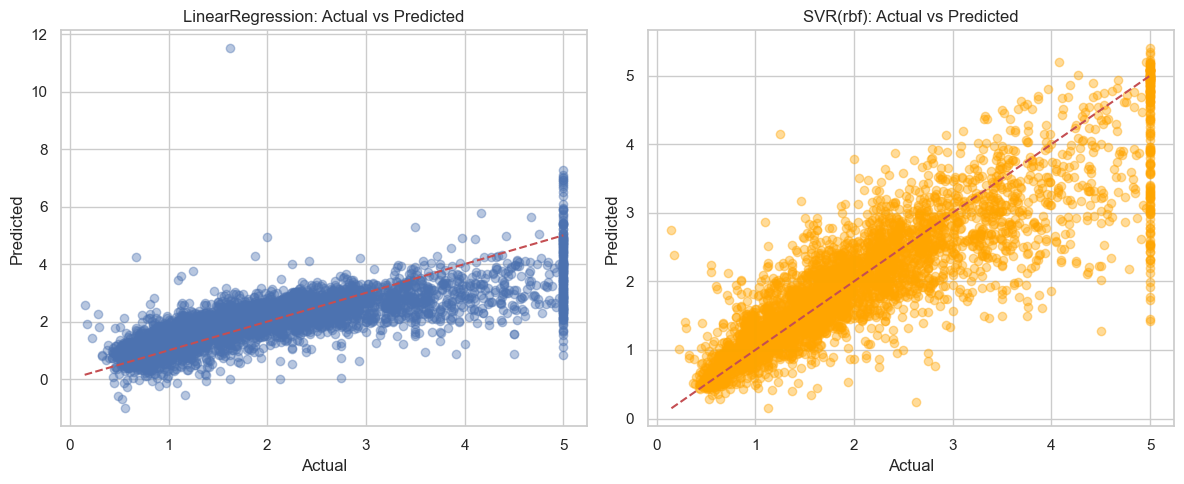

In [12]:
# 문제 3: 산점도 확인
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test_reg, pred_lr, alpha=0.4)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
axes[0].set_title('LinearRegression: Actual vs Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

axes[1].scatter(y_test_reg, pred_svr, alpha=0.4, color='orange')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
axes[1].set_title('SVR(rbf): Actual vs Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()


### 문제 3 해석 작성
- (작성) 선형 모델의 한계가 드러난 패턴
- (작성) SVR 성능 개선 이유(비선형 함수 언급)

**답안:**
1. LinearRegression의 산점도를 보면 실제값과 예측값이 직선 형태로만 표현되어, 데이터의 복잡한 패턴을 충분히 반영하지 못하는 모습을 보인다. 특히 실제값과 예측값이 직선에서 벗어나는 구간이 존재하는데, 이는 선형 모델이 비선형적인 관계를 표현하지 못하는 한계를 보여준다.
2. SVR은 RBF 커널을 사용하여 입력 데이터를 고차원 공간으로 변환한 뒤 비선형 관계를 학습할 수 있다. 이로 인해 데이터의 복잡한 패턴을 더 잘 반영할 수 있으며, LinearRegression보다 예측값이 실제값에 더 가깝게 분포하는 경향을 보인다. 따라서 비선형 함수 형태를 학습할 수 있다는 점이 SVR의 성능 개선 주요 원인이다.


### 문제 4
SVR의 `C`, `epsilon`을 바꿔 성능 변화를 관찰하고, 과적합 방지 전략을 설명하세요.


In [13]:
# 문제 4: 하이퍼파라미터 실험
C_list = [1, 10, 50]
eps_list = [0.01, 0.1, 0.3]

rows = []
for c in C_list:
    for eps in eps_list:
        # TODO 11) 루프 변수 c, eps를 SVR에 적용
        model = SVR(kernel='rbf', C=c, epsilon=eps)
        model.fit(X_train_reg_scaled, y_train_reg)
        pred = model.predict(X_test_reg_scaled)
        rows.append({
            'C': c,
            'epsilon': eps,
            'MSE': mean_squared_error(y_test_reg, pred),
            'R2': r2_score(y_test_reg, pred)
        })

# TODO 12) R2 기준 내림차순
svr_grid_result = pd.DataFrame(rows).sort_values(by='R2', ascending=False).reset_index(drop=True)
svr_grid_result


,C,epsilon,MSE,R2
0,50,0.30,0.309483,0.763827
1,50,0.10,0.316295,0.758629
2,50,0.01,0.318321,0.757083
3,10,0.30,0.319304,0.756333
4,10,0.10,0.323697,0.752980
5,10,0.01,0.324228,0.752575
6,1,0.30,0.352804,0.730768
7,1,0.10,0.357004,0.727563
8,1,0.01,0.357802,0.726954


### 문제 4 해석 작성
- (작성) `C` 증가/감소가 편향 및 분산에 미치는 영향
- (작성) `epsilon` 변화가 예측 민감도에 미치는 영향
- (작성) 결론 작성(과적합 방지 전략)

**답안:**
1. C는 모델이 학습 데이터에 얼마나 엄격하게 맞출지를 조절하는 하이퍼파라미터이다. C 값이 클수록 오차를 더 강하게 줄이려고 하여 데이터에 과도하게 맞춰지는 경향이 있어 분산이 증가하고 과적합이 발생할 수 있다. 반대로 C 값이 작으면 모델이 더 단순해져 일부 오차를 허용하게 되므로 편향은 증가하지만 분산은 감소하여 보다 일반화된 모델이 된다.
2. epsilon은 오차를 허용하는 범위를 의미하며, 값이 작을수록 작은 오차에도 민감하게 반응하여 더 정밀하게 데이터를 학습하게 된다. 이 경우 모델이 데이터의 작은 변화까지 반영하여 과적합될 가능성이 있다. 반대로 epsilon이 크면 일정 범위 내의 오차를 무시하게 되어 모델이 덜 민감해지고, 보다 부드러운 예측을 하게 된다.
3. SVR 모델에서 과적합을 방지하기 위해서는 C 값을 너무 크게 설정하지 않고 적절히 낮추어 모델의 복잡도를 제한하는 것이 중요하다. 또한 epsilon 값을 적절히 증가시켜 작은 노이즈에 과도하게 반응하지 않도록 해야 한다. 따라서 C와 epsilon을 균형 있게 조정하여 편향과 분산 사이의 적절한 균형을 맞추는 것이 효과적인 과적합 방지 전략이다.


## [Section 3] Decision Tree & Ensemble

### 문제 5
`DecisionTreeRegressor` vs `RandomForestRegressor` 성능 비교


In [14]:
# 문제 5: Bagging 비교
dt = DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE)
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)

# TODO 13) DecisionTree 학습 메서드
dt.fit(X_train_reg, y_train_reg)
# TODO 14) RandomForest 학습 메서드
rf.fit(X_train_reg, y_train_reg)
pred_dt = dt.predict(X_test_reg)
pred_rf = rf.predict(X_test_reg)

result_q5 = pd.DataFrame({
    'Model': ['DecisionTreeRegressor', 'RandomForestRegressor'],
    'MSE': [mean_squared_error(y_test_reg, pred_dt), mean_squared_error(y_test_reg, pred_rf)],
    'R2': [r2_score(y_test_reg, pred_dt), r2_score(y_test_reg, pred_rf)]
})
result_q5


,Model,MSE,R2
0,DecisionTreeRegressor,0.422045,0.677928
1,RandomForestRegressor,0.272759,0.791852


### 문제 5 해석 작성
- (작성) 왜 Random Forest가 단일 트리보다 Variance를 줄이는가?
- (작성) Diversity Theorem 관점에서 샘플 및 특성 랜덤성의 역할

**답안:**
1. 단일 트리는 데이터에 매우 민감하여 작은 변화에도 다른 구조의 트리가 생성될 수 있어 분산이 큰 모델이다. 반면 Random Forest는 Bagging을 사용하기 때문에 개별 트리의 예측 오차가 서로 상쇄되어 전체적인 분산이 감소한다. 이로 인해 더 안정적이고 일반화 성능이 좋은 모델이 된다.
2. Diversity Theorem에 따르면 앙상블 모델의 성능은 개별 모델의 정확도뿐만 아니라 모델 간 다양성에 크게 의존한다. Random Forest는 부트스트래핑을 통해 서로 다른 샘플로 학습하고, 각 분할 시 일부 특성만 무작위로 선택하여 트리를 생성함으로써 모델 간 차이를 유도한다. 이러한 샘플 및 특성의 랜덤성은 개별 트리들의 예측을 다양하게 만들어 평균 과정에서 오차를 효과적으로 줄이게 하며, 결과적으로 모델의 성능을 향상시킨다.



### 문제 6
Boosting 성능 비교 및 Residual 학습 원리


In [15]:
# 문제 6: Boosting
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=200, learning_rate=0.05, max_depth=3)

# TODO 15) GradientBoosting 학습 메서드
gbr.fit(X_train_reg, y_train_reg)
# TODO 16) GradientBoosting 예측 메서드
pred_gbr = gbr.predict(X_test_reg)

result_q6 = pd.DataFrame({
    'Model': ['LinearRegression', 'SVR(rbf)', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'MSE': [
        mean_squared_error(y_test_reg, pred_lr),
        mean_squared_error(y_test_reg, pred_svr),
        mean_squared_error(y_test_reg, pred_dt),
        mean_squared_error(y_test_reg, pred_rf),
        mean_squared_error(y_test_reg, pred_gbr)
    ],
    'R2': [
        r2_score(y_test_reg, pred_lr),
        r2_score(y_test_reg, pred_svr),
        r2_score(y_test_reg, pred_dt),
        r2_score(y_test_reg, pred_rf),
        r2_score(y_test_reg, pred_gbr)
    ]
}).sort_values('R2', ascending=False).reset_index(drop=True)
result_q6


,Model,MSE,R2
0,RandomForestRegressor,0.272759,0.791852
1,GradientBoostingRegressor,0.291214,0.777768
2,SVR(rbf),0.323697,0.752980
3,DecisionTreeRegressor,0.422045,0.677928
4,LinearRegression,0.555892,0.575788


### 문제 6 해석 작성
- (작성) GBM이 이전 단계 잔차를 어떤 방식으로 학습하는지 단계별로 설명
- (작성) 위 실험에서의 GBM과 랜덤포레스트의 성능(R2) 차이를 Bias-Variance Trade-off로 해석

**답안:**
1. GBM은 우선 모든 샘플에 대한 하나의 단순한 초기 예측값 생성 후 실제값과 예측값의 잔차를 계산한다. 이후 다음 트리가 해당 잔차를 잘 맞추도록 학습하며, 학습한 트리를 학습률만큼 더해 모델을 업데이트하는 과정을 반복해 성능을 높인다.
2. RandomForest은 여러 트리를 평균내어 분산을 크게 줄이는 방식이라 과적합에 강하고 안정적이지만, 개별 트리의 편향이 어느 정도 남아 있을 수 있다. 하지만 GBM은 잔차를 순차적으로 학습하면서 모델을 점점 복잡하게 만들어 Bias를 적극적으로 줄이는 방식이므로, 데이터의 패턴을 더 정교하게 맞출 수 있어 R2가 더 높게 나올 가능성이 있다.


## [Section 4] 결론 및 분석

### 문제 7
분류 문제에서 Accuracy가 아닌 F1-score가 중요한 상황을 확인하세요.


In [16]:
# 문제 7: 분류
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE,
    # TODO 17) 클래스 비율 유지를 위한 설정
    stratify=y_clf
)

scaler_clf = StandardScaler()
# TODO 18) 분류 데이터 학습 스케일링 메서드
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

from sklearn.ensemble import RandomForestClassifier
clf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300)
clf_model.fit(X_train_clf, y_train_clf)
pred_clf = clf_model.predict(X_test_clf)

print('Accuracy:', accuracy_score(y_test_clf, pred_clf))
print('F1-macro:', f1_score(y_test_clf, pred_clf, average='macro'))
print('F1-weighted:', f1_score(y_test_clf, pred_clf, average='weighted'))
print('\nClassification Report\n', classification_report(y_test_clf, pred_clf))


Accuracy: 1.0
F1-macro: 1.0
F1-weighted: 1.0

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



### 문제 7 해석 작성
- (작성) Accuracy가 왜 클래스 불균형 데이터에서 왜곡될 수 있는지
- (작성) F1-score를 Accuracy보다 우선 확인해야 하는 상황 예시 (앞 문항과 연결하여 작성)

**답안:**
1. Accuracy는 전체 데이터 중 맞춘 비율을 의미하기 때문에, 클래스가 불균형한 경우 다수 클래스만 잘 예측해도 높은 값을 얻을 수 있다. 예를 들어 특정 클래스가 전체의 대부분을 차지하는 경우, 모델이 해당 클래스만 예측하더라도 높은 Accuracy를 기록할 수 있어 실제 모델의 성능을 제대로 반영하지 못한다.
2. F1-score는 Precision과 Recall을 모두 고려한 지표로, 특히 소수 클래스의 예측 성능을 평가하는 데 유용하다. 예를 들어 앞 문제와 같이 여러 클래스가 존재하거나 특정 클래스의 비율이 상대적으로 낮은 경우, Accuracy만으로는 모델이 소수 클래스를 제대로 예측하는지 판단하기 어렵다. 이때 F1-score를 함께 확인하면 각 클래스에 대한 균형 잡힌 성능 평가가 가능하므로, Accuracy보다 더 중요한 지표로 활용될 수 있다.


### 문제 8
최종 선택 모델의 Feature Importance를 출력하고 도메인 관점으로 왜 이러한 결과가 나왔는지 생각해보세요 ^ㅡ^


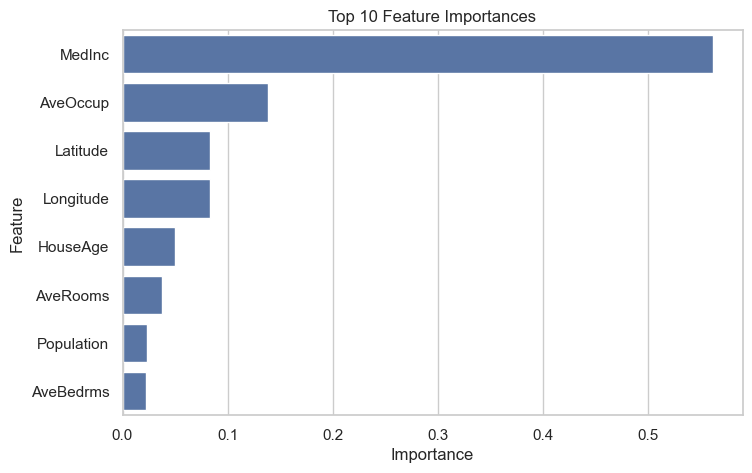

MedInc        0.561583
AveOccup      0.138812
Latitude      0.083399
Longitude     0.083280
HouseAge      0.050154
AveRooms      0.037396
Population    0.022901
AveBedrms     0.022474
dtype: float64

In [17]:
# 문제 8: 특성 중요도 시각화
final_model = rf
importance = pd.Series(final_model.feature_importances_, index=X_train_reg.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importance.values[:10], y=importance.index[:10], orient='h')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

importance.head(10)


## 제출 전 체크리스트
- [ ] Section 1~4 모든 코드 작성 및 실행
- [ ] 서술형 문항 답안 작성


긴 과제 진행하시느라 정말 고생 많으셨습니다.

코드작성과 해석을 스스로 정리해보신 만큼, 지도학습 핵심 개념을 탄탄하게 가져가는 기회가 되셨으면 합니다.
감사합니다.
